In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from sklearn.model_selection import train_test_split
from wordcloud import WordCloud

In [2]:
#Load the data.
reviews = pd.read_csv('IMDB Dataset.csv')
reviews.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


Let's look at some basic details and sample reviews.

In [3]:
reviews.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,positive
freq,5,25000


In [4]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [5]:
all_neg = reviews[reviews['sentiment']=='negative']
all_pos = reviews[reviews['sentiment']=='positive']
for i in range(3):
    print('\nPositive:\n', all_pos['review'].iloc[i])
    print('\nNegative:\n', all_neg['review'].iloc[i])


Positive:
 One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is du

We make a wordcloud to get a sense of the most common words.

(-0.5, 399.5, 199.5, -0.5)

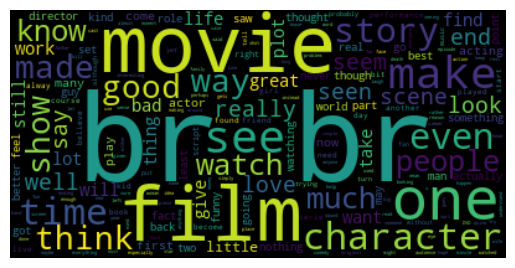

In [6]:
from itertools import chain
all_words = chain(*reviews['review'])
text = ''.join(all_words)
cloud = WordCloud().generate(text)
plt.imshow(cloud, interpolation='bilinear')
plt.axis("off")

In [7]:
#we need to deal with the linebreak text. 
reviews['review'] = reviews['review'].apply(lambda t: t.replace(r'<br />',' '))
reviews.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. The filming t...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


(-0.5, 399.5, 199.5, -0.5)

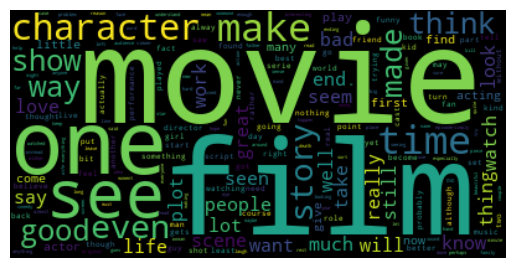

In [8]:
#Now redo the wordcloud.
all_words = chain(*reviews['review'])
text = ''.join(all_words)
cloud = WordCloud().generate(text)
plt.imshow(cloud, interpolation='bilinear')
plt.axis("off")

That's better. We need to look specifically at words that show up more often in bad reviews than good, and vice versa, so let's do the wordclouds for each type of review.

(-0.5, 399.5, 199.5, -0.5)

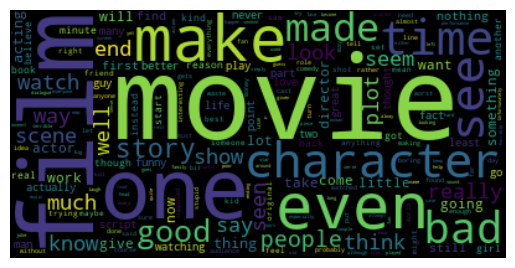

In [9]:
#negative wordcloud
all_neg = reviews[reviews['sentiment']=='negative']
all_pos = reviews[reviews['sentiment']=='positive']
all_words = chain(*all_neg['review'])
text = ''.join(all_words)
cloud = WordCloud().generate(text)
plt.imshow(cloud, interpolation='bilinear')
plt.axis("off")

(-0.5, 399.5, 199.5, -0.5)

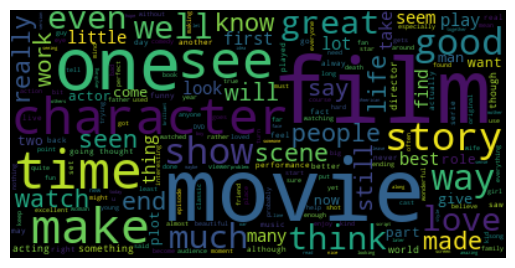

In [10]:
#positive wordcloud
all_words = chain(*all_pos['review'])
text = ''.join(all_words)
cloud = WordCloud().generate(text)
plt.imshow(cloud, interpolation='bilinear')
plt.axis("off")

We see some interesting size differences even for words that are value-neutral (e.g. "character" occurs more often in the positive reviews). But we need to make this more quantitative, of coures. First, for for some processing. We will remove stopwords, punctuation, then create a list of word stems for each review. 

In [11]:
sw = set(stopwords.words('english'))
stemmer = SnowballStemmer('english')

def process(review):
    t = word_tokenize(review)
    return [stemmer.stem(word.lower()) for word in t if (word.isalpha() and word.lower() not in sw)]

processed_reviews = reviews['review'].apply(process)

In [12]:
reviews.insert(1,'processed_review',processed_reviews)
reviews.head()

,review,processed_review,sentiment
0,One of the other reviewers has mentioned that ...,"[one, review, mention, watch, oz, episod, hook...",positive
1,A wonderful little production. The filming t...,"[wonder, littl, product, film, techniqu, fashi...",positive
2,I thought this was a wonderful way to spend ti...,"[thought, wonder, way, spend, time, hot, summe...",positive
3,Basically there's a family where a little boy ...,"[basic, famili, littl, boy, jake, think, zombi...",negative
4,"Petter Mattei's ""Love in the Time of Money"" is...","[petter, mattei, love, time, money, visual, st...",positive


A common approach to categorizing text is the "bag of words" model where each unique word is a feature. We will do this below, but first we will try a simple scoring method paired with logistic regression.

We will score the words based on how often they come up in each type of review with extremes of -1 and 1: -1 for all negative, 1 for all positive. 

At this point we also need to split the data because otherwise the scores created will depend on both the training and test data, which would be leakage.

In [13]:
reviews['sentiment']=reviews['sentiment'].apply(lambda s: 1 if s == 'positive' else 0)
train, test = train_test_split(reviews)

In [14]:
#Count the negative and positive occurrences of each word.

from collections import defaultdict
negatives = train[train['sentiment'] == 0]
positives = train[train['sentiment'] == 1]
neg_count = defaultdict(int)
pos_count = defaultdict(int)

for review in negatives['processed_review']:
    for word in review:
        neg_count[word]+=1
        
for review in positives['processed_review']:
    for word in review:
        pos_count[word]+=1
        
#Positives over negatives plus positives gives a probability of the word occurrence being in a positive review.
#If we then map p-->2p-1 we get the range -1,1. This step isn't necessary but it helps us visualize the score better.

scores = defaultdict(float) #words that don't happen to occur in training data are scored 0 (neutral)

for key in set(neg_count.keys()).union(set(pos_count.keys())):
    neg,pos = neg_count[key],pos_count[key]
    p = pos/(neg+pos)
    scores[key] = 2*p-1

Let's look at a couple of example scores for value-laden words:

In [15]:
print(scores['bad'])
print(scores['suck'])
print(scores['great'])
print(scores['love'])

-0.6032349485034907
-0.6561163387510693
0.4286740927057133
0.3665178571428571


And here are some more neutral scores:

In [16]:
print(scores['film'])
print(scores['movi'])
print(scores['make'])

0.07031459879816193
-0.1306946071527293
-0.08509259259259261


Before we continue, let's look at the distribution of scores.

<AxesSubplot:ylabel='Count'>

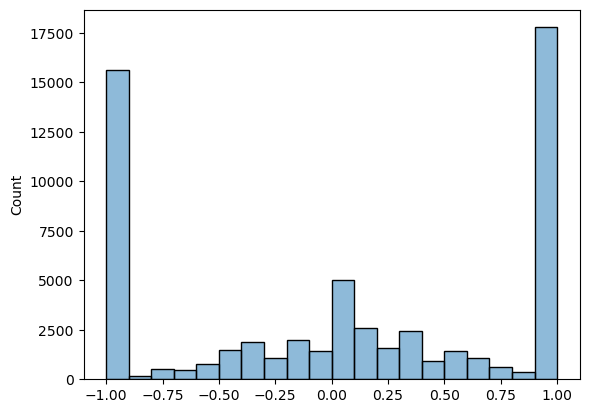

In [17]:
sns.histplot(data = scores.values(), legend = False)

What seems to be happening is that some words are on the extremes because they don't occur very often (e.g. only once), rather than having intrinsically to do with a bad review. One concern is that such words will create a lot of noise and won't work well with the test data. 

To deal with these, we could set a threshold for how many occurrences it takes for a word to be considered. However, doing this doesn't actually lead to any improvement; it doesn't result in detriment either. Changing the threshold below shows this. 

<AxesSubplot:ylabel='Count'>

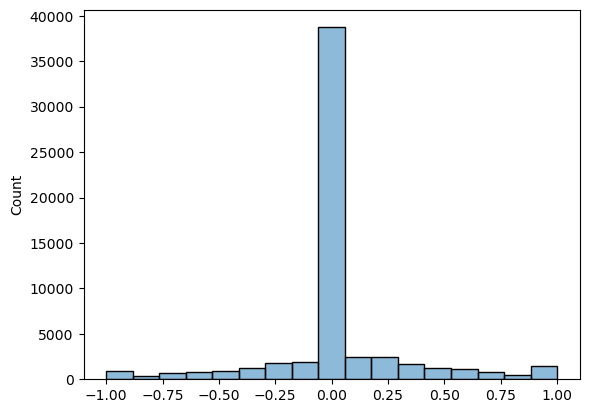

In [18]:
trimmed_scores = defaultdict(float)
threshold = 5
for key in set(neg_count.keys()).union(set(pos_count.keys())):
    neg,pos = neg_count[key],pos_count[key]
    p = pos/(neg+pos)
    trimmed_scores[key] = 2*p-1 if neg + pos >= 5 else 0
sns.histplot(data = trimmed_scores.values(), legend = False)

Now a given review can be assigned a value by averaging the scores for all it's words.

In [19]:
def review_score(processed_review):
    """Assign a numerical value to a review. Negative is bad."""
    scores = [trimmed_scores[word] for word in processed_review]
    return sum(scores)/len(scores)

#Using the word scores which were derived from the training data alone we score each review in all the data.

train_scores = train['processed_review'].apply(review_score)
test_scores = test['processed_review'].apply(review_score)

Another feature worth considering is the length of the reviews (in number of words). Let's see if there's a difference in the distribution of review length for negative versus positive reviews. 

In [20]:
neg = reviews[reviews['sentiment']==0] 
pos = reviews[reviews['sentiment']==1]
neg_lengths = neg['processed_review'].apply(len).to_frame()
pos_lengths = pos['processed_review'].apply(len).to_frame()

<AxesSubplot:ylabel='Frequency'>

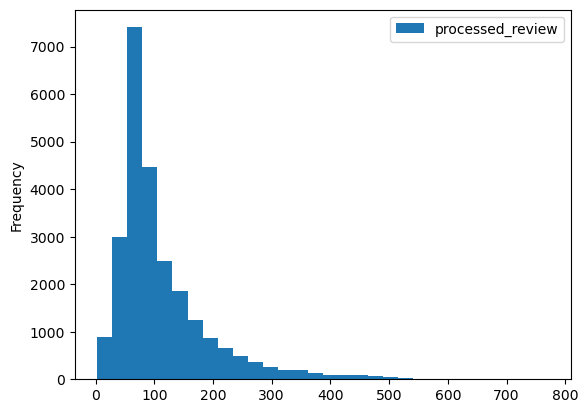

In [21]:
neg_lengths.plot(kind = 'hist', bins = 30)

<AxesSubplot:ylabel='Frequency'>

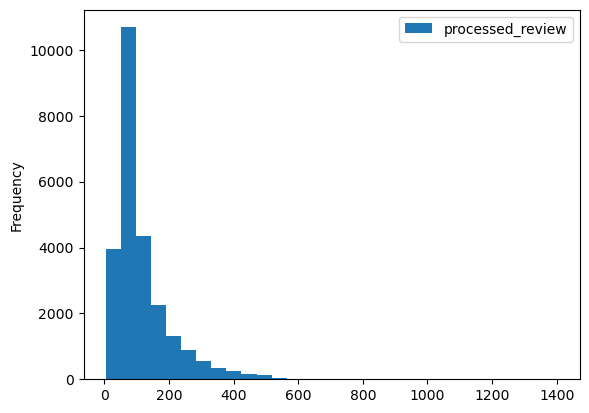

In [22]:
pos_lengths.plot(kind = 'hist', bins = 30)

These look very similar and the medians are identical:

In [23]:
print(np.median(pos_lengths))
print(np.median(neg_lengths))

85.0
85.0


So length is probably not a worthwhile feature. Now we do a logistic regression model with this single feature of review score. 

In [24]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
X_train, y_train = train_scores.to_frame(), train['sentiment']
model.fit(X_train,y_train)

LogisticRegression()

In [25]:
X_test, y_test = test_scores.to_frame(), test['sentiment']
predictions = model.predict(X_test)

Model performance:

In [26]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test,predictions))
print(confusion_matrix(y_test, predictions))

              precision    recall  f1-score   support

           0       0.86      0.84      0.85      6279
           1       0.85      0.86      0.85      6221

    accuracy                           0.85     12500
   macro avg       0.85      0.85      0.85     12500
weighted avg       0.85      0.85      0.85     12500

[[5297  982]
 [ 866 5355]]


This is pretty good performance for the approach used. Now let's do the bag of words. 

In [27]:
from sklearn.feature_extraction.text import CountVectorizer
word_bag = CountVectorizer(analyzer = process).fit(train['review'])

Apply the word bag to the training and test data.

In [28]:
train_bag = word_bag.transform(train['review'])
test_bag = word_bag.transform(test['review'])

The train and test bags are sparse matrix of thousands of features corresponding to the occurrence of individual words: each row is a message and each column corresponds to a word.

We can train the model on the train bag. We use naive bayes as it is often recommended for these sorts of problems.

In [29]:
from sklearn.naive_bayes import MultinomialNB
bayes_model = MultinomialNB()
bayes_model.fit(train_bag,y_train)
bayes_predictions = bayes_model.predict(test_bag)

In [30]:
print(classification_report(y_test,bayes_predictions))
print(confusion_matrix(y_test, bayes_predictions))

              precision    recall  f1-score   support

           0       0.84      0.88      0.86      6279
           1       0.87      0.84      0.85      6221

    accuracy                           0.86     12500
   macro avg       0.86      0.86      0.86     12500
weighted avg       0.86      0.86      0.86     12500

[[5509  770]
 [1015 5206]]


This does a little better than our original approach (however notice the asymmetry between false positives and false negatives). Another common thing to do here is apply "Tfidf": term frequency + inverse document frequency. Basically the number of word occurrences in a given review is divided by the number of words in the review (which we did in our original approach) but also multiplied by the log of the inverse frequency of the word in all of the reviews. This gives more weight to words that are less frequent (and less weight to words that are more frequent) overall in reviews. 

In [31]:
from sklearn.feature_extraction.text import TfidfTransformer
#the transformer must be fitted by the training data
tfidf = TfidfTransformer()
tfidf.fit(train_bag)
#then we apply it to the train and test
t_train_bag = tfidf.transform(train_bag)
t_test_bag = tfidf.transform(test_bag)

Let's see how well it does!

In [32]:
t_bayes_model = MultinomialNB()
t_bayes_model.fit(t_train_bag,y_train)
t_bayes_predictions = t_bayes_model.predict(t_test_bag)
print(classification_report(y_test,t_bayes_predictions))
print(confusion_matrix(y_test, t_bayes_predictions))

              precision    recall  f1-score   support

           0       0.86      0.87      0.86      6279
           1       0.87      0.85      0.86      6221

    accuracy                           0.86     12500
   macro avg       0.86      0.86      0.86     12500
weighted avg       0.86      0.86      0.86     12500

[[5487  792]
 [ 927 5294]]


Looking at the confusion matrix we see minor improvements: slightly fewer false positives and false negatives. Naive Bayes with tdidf did best.  

How could the model potentially be improved? We could do more complex analysis of the text itself, beyond counting words on the individual level: looking at relationships between words, how they occur in context, etc. NLTK has tools for sentiment analysis for this purpose, that look at text on the sentence level, and we could apply this to create new features. 

Perhaps the processing step could be improved. Was the stemmer actually helpful? Could we try different stemmers? The stopwords could also be looked at more carefully--some tweaks there might change the scoring. We could also do lemmatization.

Other broad features could be considered. Review length didn't look promising but perhaps average word length would yield something.

We could also experiment with different algorithms besides logistic regression and naive bayes. 

